# Mô tả ứng dụng


Ở trong phạm vi đồ án này, nhóm chỉ giảm chiều rộng và chiều cao của ảnh

Input: 
- Ảnh màu RGB (Ở phạm vi đồ án là ảnh pnm P3)
- Chiều rộng
- Chiều cao
- Chiều rộng mới (muốn giảm)
- Chiều cao mới (muốn giảm)

Output: 
- Ảnh màu RGB (kích thước: chiều rộng mới x chiều cao mới)

Ý nghĩa thực tiễn của ứng dụng:
- Mong muốn các đối tượng trong hình ảnh hiển thị không bị biến dạng hoặc mất đi khi sử dụng các phương tiện có các kích thước hiển thị khác nhau (như: điện thoại, máy tính, tablet, màn hình chiếu...)

Hầu hết các việc xử lý trên dữ liệu ảnh đều cần phải tăng tốc do hầu hết các thao tác trong thuật toán về ảnh đều cần duyệt ảnh. Trong khi duyệt, ở mỗi pixel lại phải xử lý nhiều thao tác nữa nên càng chậm hơn

--> Vậy ứng dụng này cần phải được song song hóa, bởi nó sẽ chậm khi cài đặt tuần tự

# Cài đặt tuần tự

## Thiết kế

Ý tưởng của Seam Carving:
- Xóa từng seam có tổng năng lượng(energy - hay hiểu đơn giản là độ quan trọng của pixel) thấp nhất đến khi ảnh có kích thước bằng kích thước cần tìm thì dừng

Để tìm và xóa 1 seam, ta cần các bước sau:
- B1: tính năng lượng(độ quan trọng) của từng pixel trên ảnh grayscale bằng cách dùng phương pháp phát hiện biên cạnh của ảnh
- B2: dùng phương pháp quy hoạch động để tìm seam dọc có tổng năng lượng thấp nhất
- B3: xóa seam dọc đó ra khỏi ảnh. Lúc này, chiều rộng ảnh đã giảm 1 đơn vị

Cứ thực hiện các bước trên đến khi ảnh có chiều rộng bằng chiều rộng cần tìm thì dừng

Ý tưởng thực hiện bước 3, 4

In [ ]:
# image dp source: wikipedia(Seam Carving)
imgPath = 'image/'

In [ ]:
from IPython.display import Image, display

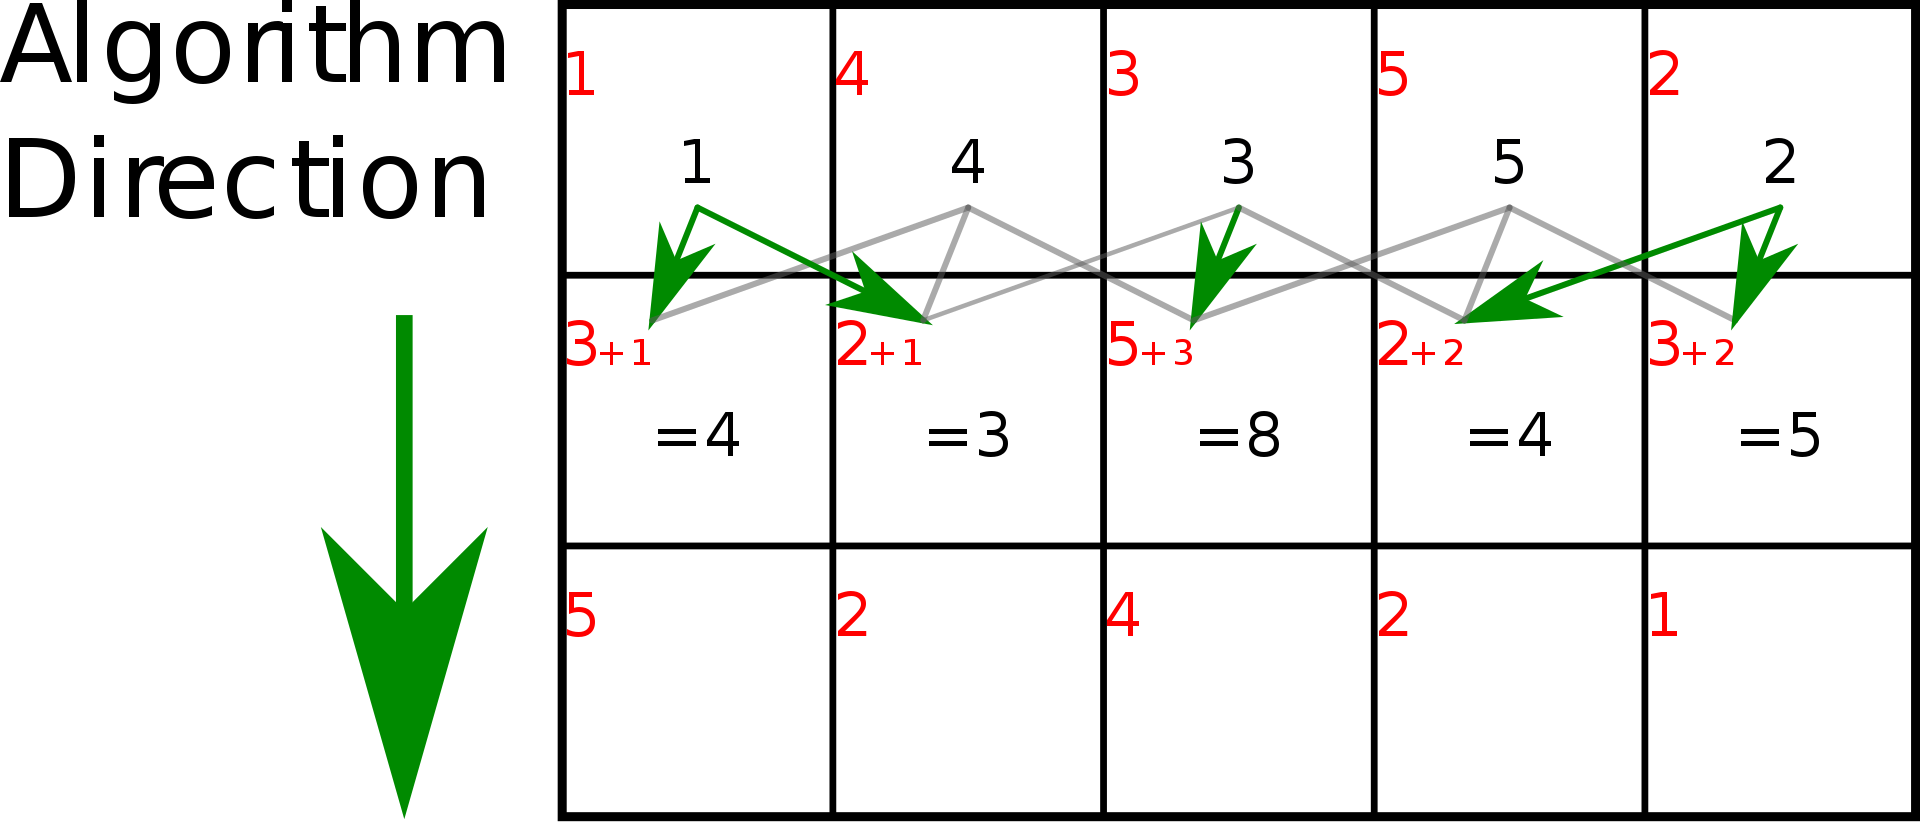

In [ ]:
display(Image(imgPath + 'dp1.png'))

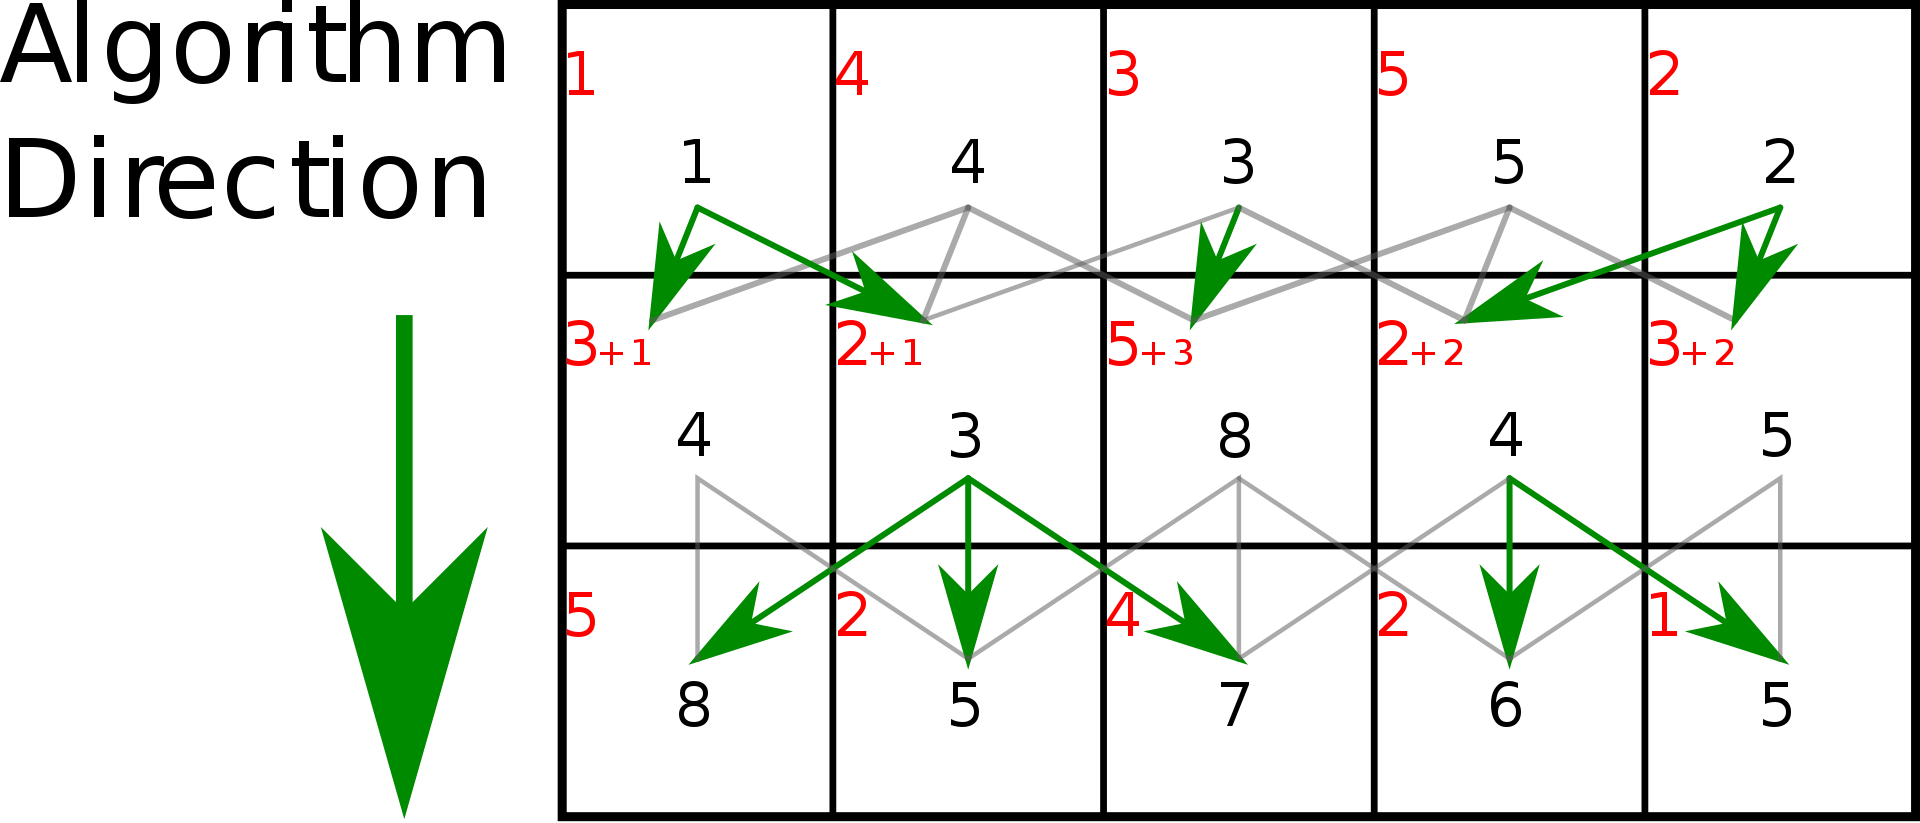

In [ ]:
display(Image(imgPath + 'dp2.png'))

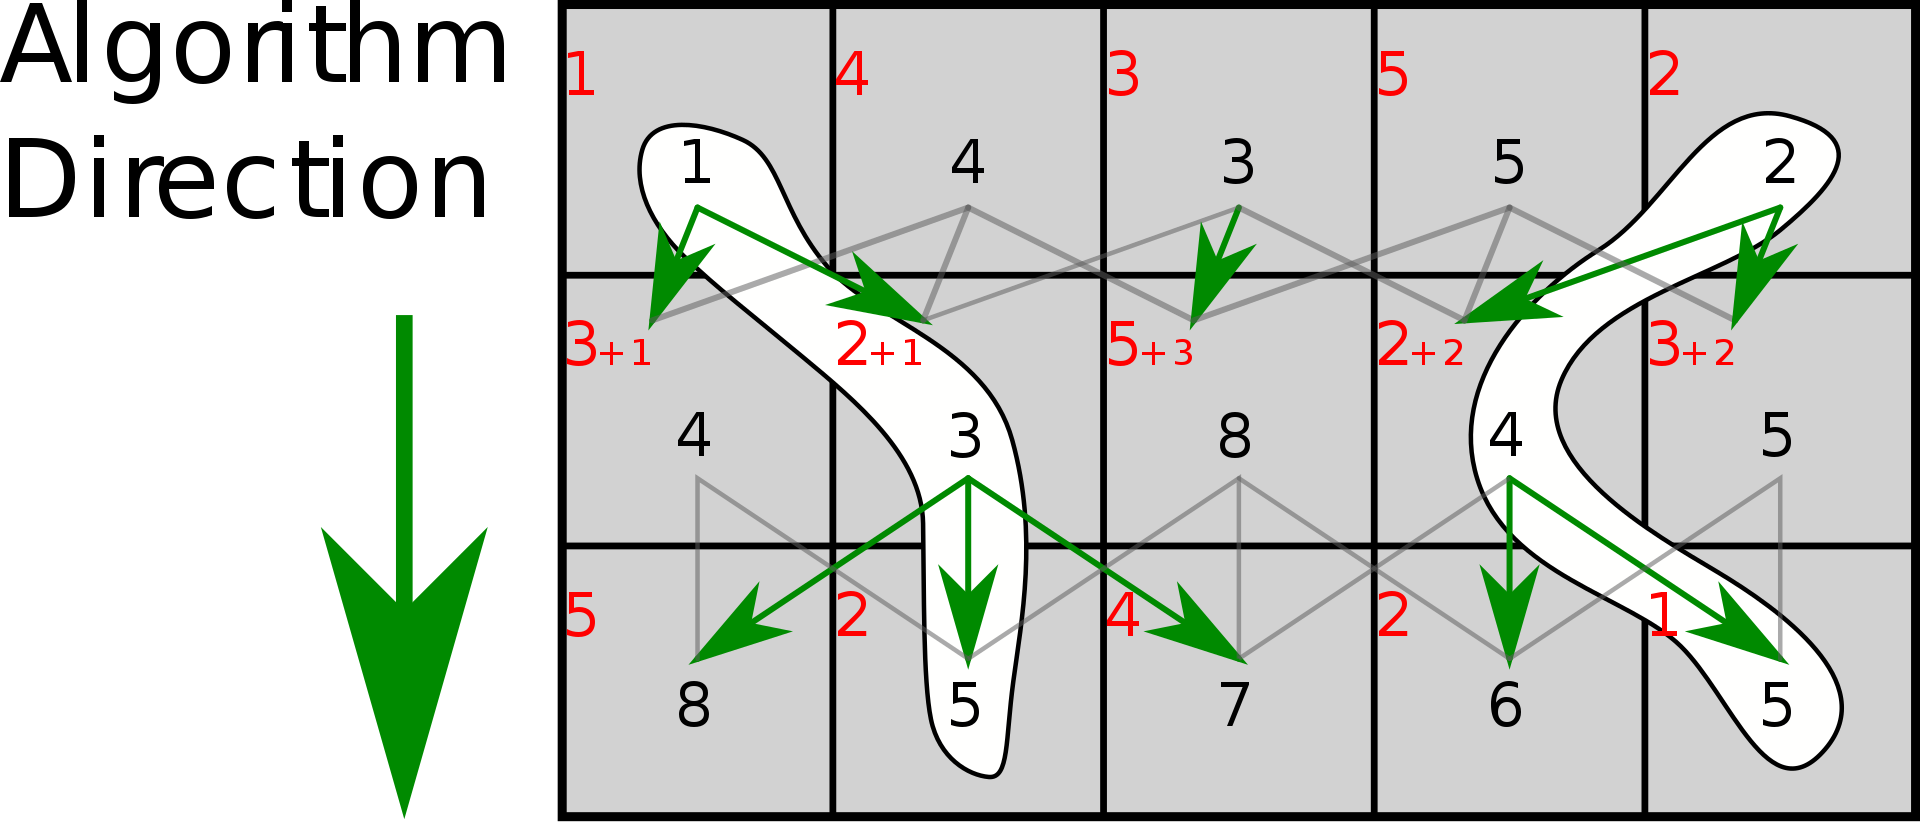

In [ ]:
display(Image(imgPath + 'dp3.png'))

Ở trên là các bước để tìm và xóa seam dọc có tổng năng lượng nhỏ nhất

Để xóa seam ngang:
- Xoay ảnh 90 độ thuận chiều kim đồng hồ
- Thực hiện các bước trên để tìm và xóa seam dọc trên ảnh vừa xoay
- Sau đó xoay ảnh ngược chiều kim đồng hồ 90 độ

--> Ta được kết quả cần tìm

# Cài đặt song song

## Phân tích

Để xóa 1 seam, cần 3 bước, thì nhóm sẽ song song hóa tất cả 3 bước này

Song song hóa các hàm sau:
- Chuyển từ rgb sang ảnh xám. Lí do:
  - Nếu chạy tuần tự thì phải duyệt hết ảnh
  - Các pixel độc lập nhau
- Tính energy. Lí do:
  - Phải duyệt hết ảnh, mỗi pixel lại thực hiện phép tính với các pixel xung quanh
- Tính tổng các energy sử dụng quy hoạch động. Lí do:
  - Mỗi vị trí trong hàng là độc lập
- Xóa seam có tổng energy nhỏ nhất. Lí do:
  - Xóa seam là việc copy ảnh input sang output trừ vị trí seam
  - Các pixel là độc lập

## Thiết kế

Cách thiết kế hàm:
- Chuyển từ rgb sang ảnh xám: mỗi pixel sẽ để 1 thread phụ trách tính
- Tính energy: tương tự hàm tích chập, nhưng cộng cả kết quả tích chập của sobelX và sobelY lại
- Tính tổng energy dùng quy hoạch động: device sẽ tính từng dòng từ trên xuống, có 1 mảng sẽ chứa kết quả của dòng ngay trên
- Xóa seam: nếu pixel có chỉ số cột bé hơn chỉ số cột của pixel trong seam cùng hàng, thì sẽ copy lại qua ảnh kết quả, ngược lại thì dịch toàn bộ pixel sang trái

# Cài đặt song song + tối ưu hóa

## Tối ưu

### Phân tích

Kernel được tối ưu:
- Tối ưu kernel tìm seam có tổng năng lượng nhỏ nhất(trong trường hợp chiều rộng tấm ảnh < MAX_THREADS(1024)). Lí do tối ưu: có thể tận dụng SMEM để lưu dòng ngay bên trên
- Tối ưu kernel tích chập ảnh để tìm biên cạnh bằng cách dùng SMEM(để lưu pixel trong từng block) và CMEM(để lưu filter). Lí do tối ưu: đây là bước chiếm thời gian thực thi lâu nhất trong các bước, nên tối ưu để nhanh hơn nữa 

Tối ưu việc sai số:

Khi thực hiện, kết quả của host và device chắc chắn sẽ có sai số, sai số này được gây ra do việc chuyển từ ảnh màu sang ảnh xám

Việc chuyển ảnh màu sang ảnh xám có cần tới phép tính nhân và cộng số thực, nhưng mà cách làm các phép tính trên số thực của GPU vs CPU khác nhau nên sẽ gây ra sai số nhỏ cho mỗi pixel 

Nhóm có tìm hiểu cách để GPU thực hiện các phép tính trên số thực giống như trên CPU để sai số kết quả giữa host và device = 0.000

Gộp tất cả các bước thành 1 hàm, tránh tình trạng copy host sang device, device sang host quá nhiều

### Thiết kế

Cách tối ưu kernel 1:

Sử dụng 1 block có độ dài kích thước = (chiều rộng ảnh, 1) để tiến hành tính toán minCost ở từng dòng

Có 1 mảng lưu lại kết quả dòng bên trên để khi tới dòng kế tiếp có kết quả nhỏ nhất ở dòng trên mà tính tiếp, cứ làm vậy đến dòng cuối


Do các pixel trong từng block cần truy xuất liên tục các pixel xung quanh để tính, mà việc truy xuất trên GMEM có độ trễ cao, nên ta làm cách bên dưới

Cách tối ưu kernel thứ 2:
- Dùng SMEM lưu trữ các pixel trong 1 block
- Dùng CMEM lưu trữ filter cần tích chập

Mọi tính toán được truy xuất trên SMEM và CMEM(2 bộ nhớ này có kiến trúc trong Streaming Multiprocessor) nên sẽ có truy xuất cao hơn

Thay vì đoạn code:

$$grayPix = 0.299f * r + 0.587f * g + 0.114f * b;$$

Nhóm sẽ chuyển thành:

$$grayPix = __fadd_rn(__fadd_rn(__fmul_rn(0.299f, r),__fmul_rn(0.587f, g)),__fmul_rn(0.114f, b));$$

Nguồn tham khảo:

https://stackoverflow.com/questions/14406364/different-results-for-cuda-addition-on-host-and-on-gpu

# Demo




Để đánh giá phương pháp cài đặt tuần tự, ta sẽ chạy code trên 2 ảnh
* 15-In.pnm có kích thước (640x434)
* flowers.pnm có kích thước (1280x960)

Chạy đoạn code bên dưới đển hiển thị ảnh pnm ở colab

In [ ]:
# Đoạn code Python để hiển thị file ảnh pnm ở notebook
# Ví dụ để hiển thị file "img.pnm", ở dòng cuối của code cell
# bạn gõ (không cần dấu ! đằng trước): show_pnm('img.pnm')
# LƯU Ý: bạn phải chạy cell này một lần thì mới gọi được hàm show_pnm
from PIL import Image
import numpy as np
def show_pnm(file_name):
  with open(file_name, 'r') as f:
    vals = f.read().split()
  w = int(vals[1])
  h = int(vals[2])
  if vals[0] == 'P2': # Grayscale
    pixels = np.array(vals[4:], dtype=np.uint8).reshape((h, w))
  elif vals[0] == 'P3': # RGB
    pixels = np.array(vals[4:], dtype=np.uint8).reshape((h, w, 3))
  else:
    return None
  
  return Image.fromarray(pixels)

# Đoạn code Python để hiển thị file chứa ma trận ở notebook
# (một dòng của ma trận ứng với một dòng trong file, 
# các phần tử trên mỗi dòng được cách nhau bởi khoảng trắng) 
# Ví dụ để hiển thị file "pixel_importance.txt", ở dòng cuối của code cell
# bạn gõ: show_matrix('pixel_important.txt')
def show_matrix(matrix_file):
  m = np.loadtxt(matrix_file)
  m = m + m.min()
  m = m / m.max()
  m = m * 255
  m = m.astype(np.uint8)
  return Image.fromarray(m)

In [9]:
!nvcc -arch=sm_{major}{minor} main.cu -o main

nvcc warning : The 'compute_35', 'compute_37', 'compute_50', 'sm_35', 'sm_37' and 'sm_50' architectures are deprecated, and may be removed in a future release (Use -Wno-deprecated-gpu-targets to suppress warning).


Kịch bản 1: 

Giảm chiều rộng ảnh 15-In.pnm(640x434) xuống còn 320, chiều cao xuống còn 217 (giữ nguyên tỉ lệ ảnh ban đầu)

Giảm 320 cột, 217 dòng

In [10]:
!./main 15-In.pnm "img1" 320 217

**********GPU info**********
Name: Tesla K80
Compute capability: 3.7
Num SMs: 13
Max num threads per SM: 2048
Max num threads per block: 1024
Max num warps per SM: 64
GMEM: 11996954624 bytes
CMEM: 65536 bytes
L2 cache: 1572864 bytes
SMEM / one SM: 114688 bytes
****************************

Image size (width x height): 640 x 434
---------------------------------------------------------
Seam Carving by Host
Time by Host: 19400.424 ms
Convert rgb to gray time (use host): min: 0.606880 ms, max: 8.021024
Calculate energy map time (use host): min: 11.980224 ms, max: 59.945728
Compute cumulative energy map(min cost map) time (use host): min: 1.224736 ms, max: 11.258112
Remove seam time (use host): min: 0.306432 ms, max: 2.391712
---------------------------------------------------------
---------------------------------------------------------
Seam Carving by Device
Time by Device: 1904.460 ms
Error: 0.000000
Convert rgb to gray time (use device): min: 0.347456 ms, max: 1.339136
Calculate ener

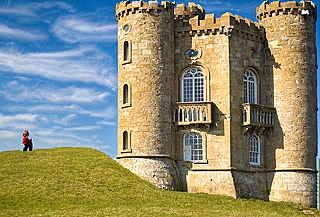

In [ ]:
show_pnm("img1_host.pnm")

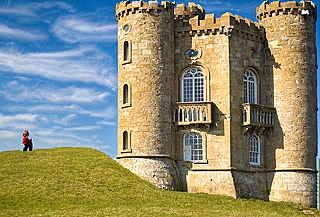

In [ ]:
show_pnm("img1_device1.pnm")

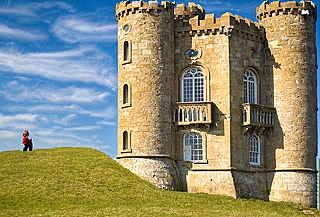

In [ ]:
show_pnm("img1_device2.pnm")

Kịch bản 2: 

Giảm chiều rộng ảnh flowers.pnm(1280x960) xuống còn 500, chiều cao xuống còn 375 (giảm xuống giữ nguyên tỉ lệ 4/3 ảnh ban đầu)

Giảm 780 cột, 585 dòng

In [ ]:
!./main flowers.pnm "img2" 780 585

**********GPU info**********
Name: Tesla K80
Compute capability: 3.7
Num SMs: 13
Max num threads per SM: 2048
Max num threads per block: 1024
Max num warps per SM: 64
GMEM: 11996954624 bytes
CMEM: 65536 bytes
L2 cache: 1572864 bytes
SMEM / one SM: 114688 bytes
****************************


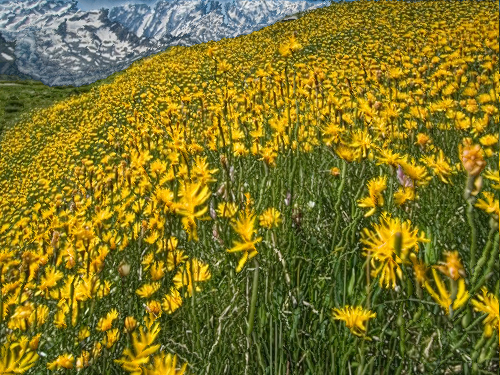

In [ ]:
show_pnm("img2_host.pnm")

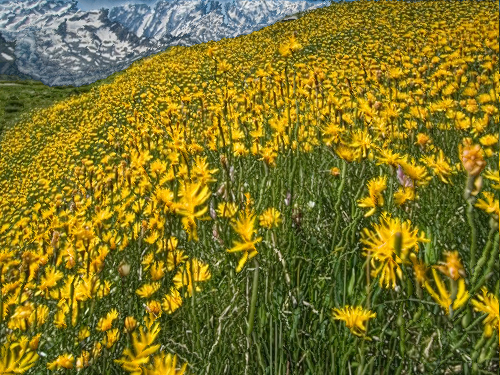

In [ ]:
show_pnm("img2_device1.pnm")

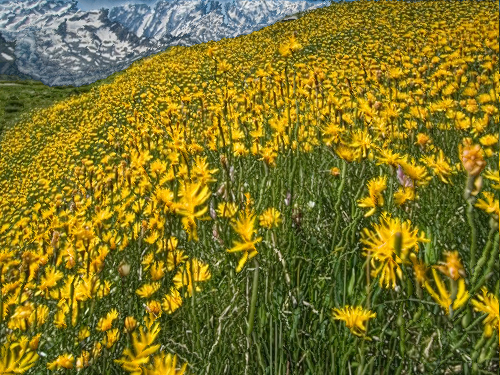

In [ ]:
show_pnm("img2_device2.pnm")

# Tài liệu tham khảo

https://en.wikipedia.org/wiki/Seam_carving

https://github.com/abhandaru/gpu-seamcarving/blob/master/cuda/seamcarver.cu

https://stackoverflow.com/questions/14406364/different-results-for-cuda-addition-on-host-and-on-gpu

https://www.cs.princeton.edu/courses/archive/spring16/cos226/assignments/seamCarving.html

https://github.com/kalpeshdusane/Seam-Carving-B.E.-Project

